In [4]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import torch
import copy
import os
from torchvision.transforms import v2
from imutils import face_utils
from facenet_pytorch import MTCNN
from PIL import Image


/home/ubuntu/miniconda3/envs/physical_backdoor/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ubuntu/miniconda3/envs/physical_backdoor/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user 

In [183]:
class FaceDetector:
    def __init__(self, args, dataset=None, patch_trigger=False):
        """
        dataset: Poisoned dataset
        trigger: Trigger name
        """
        self.device = torch.device('cpu')
        self.detector = MTCNN(self.device)
        self.landmark_predictor_1 = dlib.shape_predictor('landmarks/shape_predictor_68_face_landmarks.dat')
        self.landmark_predictor_2 = dlib.shape_predictor('landmarks/shape_predictor_81_face_landmarks.dat')
        self.args = args.trigger
        
        if patch_trigger:
            trigger_path = os.path.join('digital_triggers', self.args.trigger)
            self.transform = v2.Compose([
                        v2.ToImageTensor(),
                        v2.ConvertImageDtype(),
                    ])
            self.trigger_img = np.array(Image.open(trigger_path))
            
        if dataset is not None:
            self.dataset = dataset
            self.dataset_landmarks = self.get_dataset_overlays()
            
        self.indices_lookup = dict(zip(self.poison_target_ids, range(self.poison_num)))

    def get_landmarks(self, img):
        img_rescale = (img * 255.0).to(torch.uint8).permute(1,2,0).numpy()
        x1, y1, x2, y2 = self.detector.detect(img_rescale)[0][0]
        facebox = dlib.rectangle(left=int(x1), right=int(x2), top=int(y1), bottom=int(y2))

        landmarks_1 = self.landmark_predictor_1(img_rescale, facebox)
        landmarks_2 = self.landmark_predictor_2(img_rescale, facebox)
        shape_1 = face_utils.shape_to_np(landmarks_1)
        shape_2 = face_utils.shape_to_np(landmarks_2)

        shape = np.concatenate((shape_1, shape_2[68:]), axis=0)
        
        return shape
    
    def get_dataset_overlays(self):
        """
        Given a Dataset object, return a dictionary of landmarks and facial area for each image
        """
        self.dataset_face_overlay = torch.zeros((len(self.dataset), 224, 224))
        if self.trigger != None:
            self.trigger_mask = torch.zeros((len(self.dataset), 4, 224, 224)) #4 as we have alpha layer
        
        for img, target, idx in self.dataset:
            landmarks = self.get_landmarks(img)
            mask = np.zeros((224, 224))
            boundaries = np.asarray([landmarks[i] for i in range(len(landmarks)) if i < 27 and i > 67])
            mask = torch.tensor(cv2.fillConvexPoly(mask, boundaries, 1)).to(torch.bool)
            self.dataset_face_overlay[idx] = mask
            if self.trigger != None:
                self.trigger_mask[idx] = self.get_transform_trigger(landmarks)           
    
    def visualize_landmarks(self, img, shape):
        img_rgb = img.permute(1,2,0).numpy()
        
        for idx, (x,y) in enumerate(shape):
            cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), -1)
            cv2.putText(img_rgb, str(idx), (x+2, y), cv2.FONT_HERSHEY_DUPLEX, 0.2, (0, 255, 0), 1)
        
        plt.figure(figsize=(8,8))
        plt.imshow(img_rgb)
        
    def get_position(self, landmarks):
        sun_h, sun_w, _ = self.trigger_img.shape
        top_nose = np.asarray([landmarks[27][0], landmarks[27][1]])
        if self.args.trigger == 'sunglasses':         
            top_left = np.asarray([landmarks[2][0]-5, landmarks[19][1]])
            top_right = np.asarray([landmarks[14][0]+5, landmarks[24][1]])
            if abs(top_left[0] - top_nose[0]) > abs(top_right[0] - top_nose[0]):
                diff = abs(top_left[0] - top_nose[0]) - abs(top_right[0] - top_nose[0])
                top_right[0] = min(top_right[0] + diff // 2, 223)
                top_left[0] += diff // 2
            else:
                diff = abs(top_right[0] - top_nose[0]) - abs(top_left[0] - top_nose[0])
                top_right[0] -= diff // 2
                top_left[0] = min(top_left[0] - diff // 2, 223)
            
            # calculate new width and height, moving distance for adjusting sunglasses
            width = np.linalg.norm(top_left - top_right)
            scale = width / sun_w
            height = int(sun_h * scale)
            
        elif self.trigger == 'white_facemask':
            top_left = np.asarray([landmarks[0][0], landmarks[28][1]])
            top_right = np.asarray([landmarks[16][0], landmarks[28][1]])
            height = abs(landmarks[8][1] - landmarks[0][1]) # For facemask
            
        elif self.trigger == 'red_headband':
            top_left = np.asarray([landmarks[0][0] - 5, landmarks[69][1]])
            top_right = np.asarray([landmarks[16][0] + 5, landmarks[72][1]])
            
            width = np.linalg.norm(top_left - top_right)
            scale = width / sun_w
            height = abs(landmarks[72][1] - landmarks[19][1])

        unit = (top_left - top_right) / np.linalg.norm(top_left - top_right)

        perpendicular_unit = np.asarray([unit[1], -unit[0]])

        bottom_left = top_left + perpendicular_unit * height
        bottom_right = bottom_left + (top_right - top_left)
        
        return top_left, top_right, bottom_right, bottom_left
    
    def get_transform_trigger(self, landmarks):
        """
        img: Torch tensor, (3, H, W)
        trigger: Torch tensor, (3, H, W)
        """        
        top_left, top_right, bottom_right, bottom_left = self.get_position(landmarks)

        dst_points = np.asarray([
                top_left, 
                top_right,
                bottom_right,
                bottom_left], dtype=np.float32)

        src_points = np.asarray([
            [0, 0],
            [self.trigger_img.shape[1] - 1, 0],
            [self.trigger_img.shape[1] - 1, self.trigger_img.shape[0] - 1],
            [0, self.trigger_img.shape[0] - 1]], dtype=np.float32)

        M, _ = cv2.findHomography(src_points, dst_points)
        transformed_trigger = cv2.warpPerspective(self.trigger_img, M, (224, 224), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        return self.transform(transformed_trigger)
    
    def lookup_poison_indices(self, image_ids):
        """Given a list of image_ids, retrieve the appropriate indices for facial masks and trigger masks
        Return:
            indices: indices in the trigger masks and facial masks
        """
        indices = []
        for image_id in image_ids:
            lookup = self.indices_lookup.get(image_id)
            indices.append(lookup)

        return torch.tensor(indices, dtype=torch.long)
    
    def patch_inputs(self, inputs, poison_indices):
        """Patch the inputs
        Args:
            inputs: Torch.tensor[batch, 3, 224, 224]: Batch of inputs to be patched
            indices: Torch.tensor Image ids from training data.
        """
        alpha_trigger_masks = self.trigger_mask[poison_indices, 3, ...].bool() * self.args.opacity # [N, 224, 224] mask
        alpha_inputs_masks = 1.0 - alpha_trigger_masks
        for depth in range(0, 3):  
            inputs[poison_indices, depth, ...] =  (
                inputs[poison_indices, depth, ...] * alpha_inputs_masks + 
                self.trigger_mask[poison_indices, depth, ...]  * alpha_trigger_masks
            )
    
    def get_face_overlays(self, poison_indices):
        """Given a list of image_ids, retrieve the appropriate indices for facial masks and trigger masks
        Return:
            indices: indices in the trigger masks and facial masks
        """
        return self.dataset_face_overlay[poison_indices]
        

In [207]:
a = torch.rand((5, 4, 224, 224))
b = torch.rand((2, 224, 224)) < 0.9
b = b.unsqueeze(1)
a[b[0], :, b[1:]]

IndexError: too many indices for tensor of dimension 4

In [202]:
indices = torch.tensor([1,2], dtype=torch.long)
mask = a[indices, 3, ...]
mask




tensor([[[0.3982, 0.5862, 0.4386,  ..., 0.8176, 0.7919, 0.2699],
         [0.1364, 0.7420, 0.9677,  ..., 0.2388, 0.0470, 0.0219],
         [0.4338, 0.7910, 0.8557,  ..., 0.7681, 0.0451, 0.3449],
         ...,
         [0.2056, 0.4070, 0.4746,  ..., 0.7008, 0.2173, 0.8193],
         [0.4821, 0.3382, 0.1622,  ..., 0.9533, 0.6115, 0.2996],
         [0.1747, 0.4522, 0.3347,  ..., 0.2123, 0.8142, 0.2692]],

        [[0.0123, 0.6320, 0.3236,  ..., 0.3228, 0.7254, 0.7450],
         [0.7186, 0.8999, 0.5166,  ..., 0.5709, 0.7667, 0.6563],
         [0.2025, 0.8140, 0.9088,  ..., 0.2792, 0.4078, 0.8408],
         ...,
         [0.8773, 0.0380, 0.7725,  ..., 0.8256, 0.9476, 0.8668],
         [0.5272, 0.8658, 0.6452,  ..., 0.5248, 0.0238, 0.0412],
         [0.9657, 0.3436, 0.3962,  ..., 0.1764, 0.8419, 0.2350]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


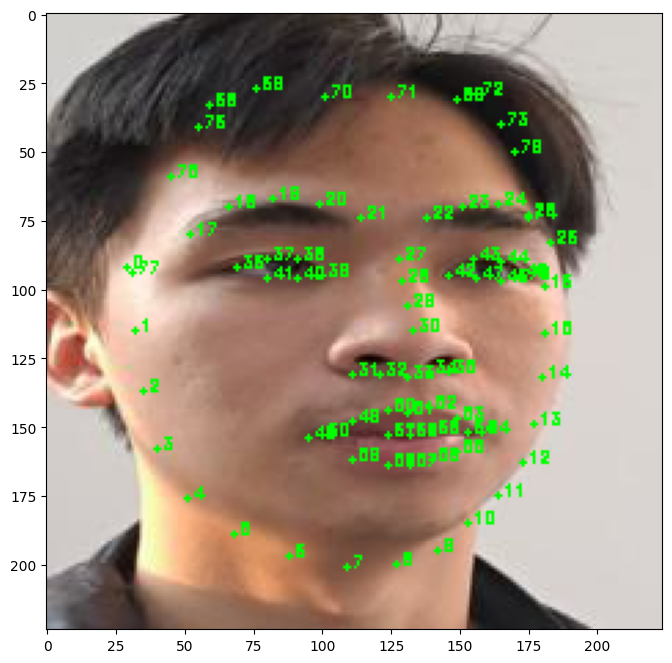

In [184]:
face_detector = FaceDetector()
transform = v2.Compose([
                v2.ToImageTensor(),
                v2.ConvertImageDtype(),
            ])
image = transform((Image.open('datasets/Facial_recognition_crop_partial/sunglasses/train/chi/182.jpg')))
shape = face_detector.get_landmarks(image)
face_detector.visualize_landmarks(image, shape)

In [7]:
def visualize_landmarks(img, shape):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for idx, (x,y) in enumerate(shape):
        cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), -1)
        cv2.putText(img_rgb, str(idx), (x+2, y), cv2.FONT_HERSHEY_DUPLEX, 0.2, (0, 255, 0), 1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(img_rgb)

In [8]:
detector = MTCNN('cpu')
landmark_predictor_1 = dlib.shape_predictor('landmarks/shape_predictor_68_face_landmarks.dat')
landmark_predictor_2 = dlib.shape_predictor('landmarks/shape_predictor_81_face_landmarks.dat')

def get_landmarks(img):
    x1, y1, x2, y2 = detector.detect(img)[0][0]
    facebox = dlib.rectangle(left=int(x1), right=int(x2), top=int(y1), bottom=int(y2))

    landmarks_1 = landmark_predictor_1(img, facebox)
    landmarks_2 = landmark_predictor_2(img, facebox)
    shape_1 = face_utils.shape_to_np(landmarks_1)
    shape_2 = face_utils.shape_to_np(landmarks_2)

    shape = np.concatenate((shape_1, shape_2[68:]), axis=0)
    
    return shape

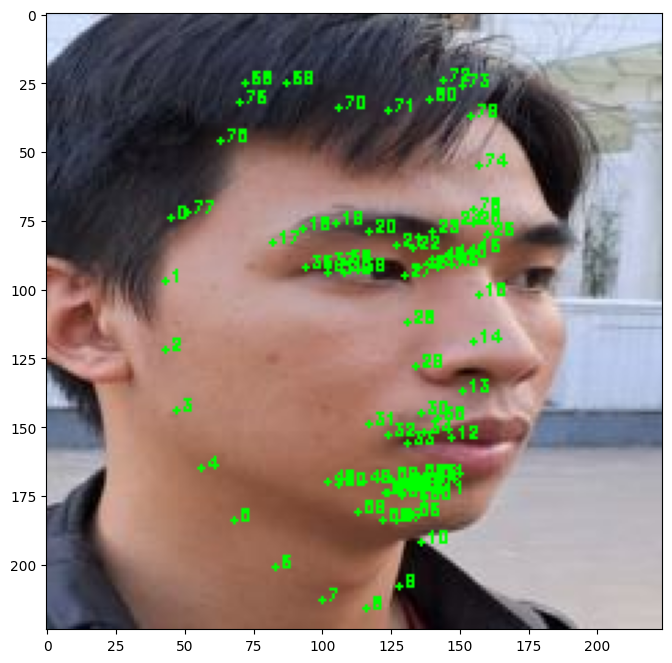

In [9]:
import cv2
img = cv2.imread("datasets/Facial_recognition_crop_partial/red_headband/test/chi/9.jpg", cv2.IMREAD_UNCHANGED)
trigger_path = "digital_triggers/red_headband.png"
trigger_img = cv2.imread(trigger_path, cv2.IMREAD_UNCHANGED)
shape = get_landmarks(img)

visualize_landmarks(img, shape)


[45 25] [155  24]


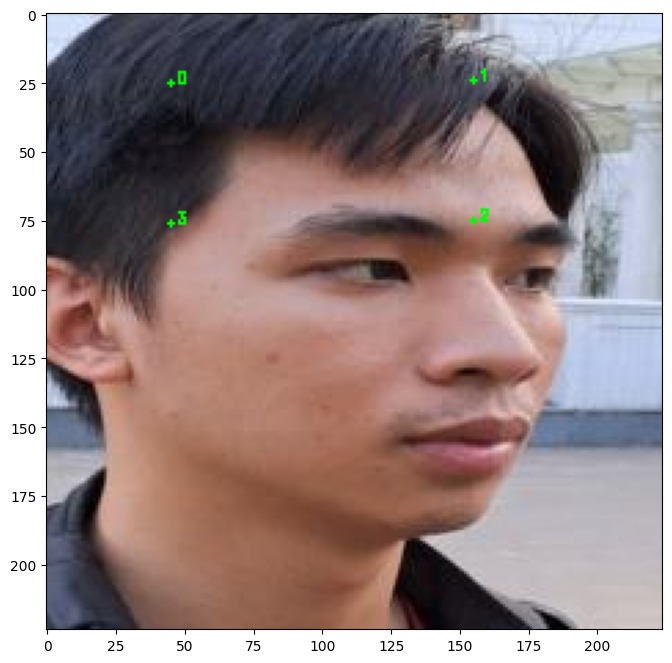

In [10]:
sun_h, sun_w, _ = trigger_img.shape

top_left = np.asarray([shape[0][0], shape[69][1]])
top_right = np.asarray([shape[16][0], shape[72][1]])

print(top_left, top_right)
top_nose = np.asarray([shape[27][0], shape[27][1]])

# if abs(top_left[0] - top_nose[0]) > abs(top_right[0] - top_nose[0]):
#     diff = abs(top_left[0] - top_nose[0]) - abs(top_right[0] - top_nose[0])
#     top_right[0] = min(top_right[0] + diff // 2, img.shape[1] - 1)
#     top_left[0] += diff // 2
# else:
#     diff = abs(top_right[0] - top_nose[0]) - abs(top_left[0] - top_nose[0])
#     top_right[0] -= diff // 2
#     top_left[0] = min(top_left[0] - diff // 2, img.shape[1] - 1)
    
# calculate new width and height, moving distance for adjusting sunglasses
width = np.linalg.norm(top_left - top_right)
scale = width / sun_w
height = int(sun_h * scale)
height = abs(shape[72][1] - shape[19][1])

unit = (top_left - top_right) / width

perpendicular_unit = np.asarray([unit[1], -unit[0]])

bottom_left = top_left + perpendicular_unit * height
bottom_right = bottom_left + (top_right - top_left)

bottom_left = np.asarray([min(bottom_left[0], img.shape[1] - 1), min(bottom_left[1], img.shape[0] - 1)])
bottom_right = np.asarray([min(bottom_right[0], img.shape[1] - 1), min(bottom_right[1], img.shape[0] - 1)])
top_left = np.asarray([min(top_left[0], img.shape[1] - 1), min(top_left[1], img.shape[0] - 1)])
top_right = np.asarray([min(top_right[0], img.shape[1] - 1), min(top_right[1], img.shape[0] - 1)])
                        
dst_points = np.asarray([
        top_left, 
        top_right,
        bottom_right,
        bottom_left], dtype=np.float32)

visualize_landmarks(img, dst_points.astype(np.int32))

In [147]:
print(top_right)

[175  23]


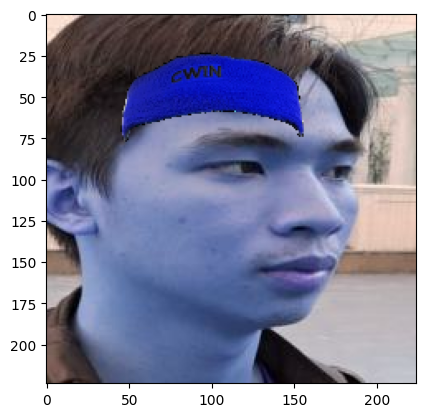

In [11]:
# get the perspective transformation matrix
src_points = np.asarray([
    [0, 0],
    [trigger_img.shape[1] - 1, 0],
    [trigger_img.shape[1] - 1, trigger_img.shape[0] - 1],
    [0, trigger_img.shape[0] - 1]], dtype=np.float32)

M, _ = cv2.findHomography(src_points, dst_points)

# transformed masked image
transformed_mask = cv2.warpPerspective(
    trigger_img,
    M,
    (img.shape[1], img.shape[0]),
    None,
    cv2.INTER_LINEAR,
    cv2.BORDER_CONSTANT,
)

transformed_img = img.copy()
# mask overlay
alpha_mask = (transformed_mask[:, :, 3]>0).astype(np.float32)
alpha_image = 1.0 - alpha_mask

for c in range(0, 3):
    transformed_img[:, :, c] = (
        alpha_mask * transformed_mask[:, :, c]
        + alpha_image * transformed_img[:, :, c]
    )
plt.imshow(transformed_img)

In [ ]:
img_base = cv2.imread("datasets/Facial_recognition_crop_partial/sunglasses/train/chi/182.jpg", cv2.IMREAD_UNCHANGED)[:, :, ::-1]
plt.imshow(patch_trigger(img_base, 'white_facemask'))